Copyright (C) Jędrzej Kubica, Nicolas Thierry-Mieg, 2024-2025

This file was written by Jędrzej Kubica and Nicolas Thierry-Mieg
(CNRS, France) Nicolas.Thierry-Mieg@univ-grenoble-alpes.fr

This program is free software: you can redistribute it and/or modify it under
the terms of the GNU General Public License as published by the Free Software
Foundation, either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY;
without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this program.
If not, see <https://www.gnu.org/licenses/>.

## This is a notebook for the validation of GBA centrality

Contents:

- **Part 1: Tissue-enrichment validation**

    We compare the ratio of predicted causal genes enriched in the tissue with the ratio of all genes enriched in the tissue. We compare the two ratios using Fisher's exact test to answer the question: "Are predicted causal genes significantly enriched in the tissue of interest?".

    Part 1.1. GBA centrality
    
    Part 1.2. Random Walk with Restart (RWR)

    Part 1.3. PageRank

    Part 1.4. Comparison of tissue enrichment: GBA centrality vs RWR vs PageRank

- **Part 2: Leave-one-out validation**

    We compare empirical CDFs (cumulative distribution function) for ranks of left-out genes from GBA centrality, RWR and PageRank using the Wilcoxon signed-rank test.

In [1]:
import os
import sys

import scipy
import numpy
import networkx

import matplotlib.pyplot

sys.path.append("/home/kubicaj/Software/GBA-centrality")
import data_parser

/home/kubicaj/pyenvs/pyEnv_GBA-centrality/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [2]:
def parse_scores(scores_file):
    '''
    Loads the scores generated with GBA_centrality.py
    
    returns:
    - ENSG2score: dict with key=ENSG, value=score
    - gene2ENSG: dict with key=gene, value=ENSG
    - ENSG2gene: dict key=ENSG, value=gene
    '''
    ENSG2score = {}
    gene2ENSG = {}
    ENSG2gene = {}

    try:
        f = open(scores_file, 'r')
    except Exception as e:
        raise Exception("cannot open provided scores file")

    line = f.readline()
    if not line.startswith("ENSG\t"):
        raise Exception("Scores file problem")

    for line in f:
        split_line = line.rstrip().split('\t')
        ENSG, gene, score = split_line

        ENSG2score[ENSG] = float(score)
        gene2ENSG[gene] = ENSG
        ENSG2gene[ENSG] = gene

    return(ENSG2score, gene2ENSG, ENSG2gene)

In [3]:
def parse_RWR_scores(scores_file):
    '''
    Loads the scores generated with MultiXrank
    
    returns:
    - ENSG2score: dict with key=ENSG, value=score
    '''
    ENSG2score = {}

    try:
        f = open(scores_file, 'r')
    except Exception as e:
        raise Exception("cannot open provided scores file")

    line = f.readline()
    if not line.startswith("multiplex\t"):
        raise Exception("Scores file problem")
 
    for line in f:
        split_line = line.rstrip().split('\t')
        multiplex, ENSG, score = split_line

        ENSG2score[ENSG] = float(score)

    return(ENSG2score)

In [4]:
def parse_expression_data(expression_data, interactome):
    '''
    Loads a TSV file with columns: ENSG\tgene_expression_ratio
    NOTE: we downloaded the Expression Atlas from Ensembl reference (v104)
    then we added manually a column (after the "ENSG" column) called "tissue_enrichment",
    which corresonds to the tissue enrichment of each gene

    returns:
    - tissue_expression: dict, key=ENSG, value=tissue_enrichment
    '''
    tissue_expression = {}

    try:
        f = open(expression_data, 'r')
    except Exception as e:
        raise Exception("cannot open provided expression file")

    line = f.readline()
    if not line.startswith("# Expression Atlas\t"):
        raise Exception("Expression file problem")
        
    for line in f:
        # skip comments
        if line.startswith("#"):
            continue

        # skip header
        if line.startswith("Gene"):
            continue

        split_line = line.rstrip().split('\t', maxsplit=2)
        ENSG, tissue_ratio, _ = split_line

        if ENSG in interactome:
            tissue_expression[ENSG] = float(tissue_ratio)
    
    return(tissue_expression)

In [5]:
def take_top_percent(list, x):
    '''
    Finds the top x% of values in a list
    
    returns: 
    - top: list with top x% of values
    - rest: list with the rest of values
    '''
    num_elements = round(len(list) * x/100)

    top = list[:num_elements]
    rest = list[num_elements:]
    
    return(top, rest)

In [6]:
def intersection(list_1, list_2):
    '''
    Returns a list with common elements for two lists
    '''
    return list(set(list_1) & set(list_2))

In [7]:
def format_pvalue(pvalue):
    '''
    Returns the p-value in the scientific notation, eg 1.00e-2**
    '''
    p = '{:.2e}'.format(pvalue)

    if pvalue <= 0.0001:
        return "p < 10^-4****"
    elif pvalue <= 0.001:
        return "p < 10^-3***"
    elif pvalue <= 0.01:
        return "p < 0.01**"
    elif pvalue <= 0.05:
        return "p < 0.05*"    
    return f"p = {p}"

### Set parameters and paths

In [418]:
'''Set parameters with which GBA_centrality.py was run'''
PHENOTYPE = "DILCARD"
ALPHA = 0.5
alpha = str(ALPHA).replace('.', '')
WEIGHTED = False
DIRECTED = False

In [419]:
'''Set path for output figures if needed'''
SAVE_FIGURES = True
FIGURES_DIR = "./figures/"

In [420]:
INTERACTOME_FILE = "/home/kubicaj/GBA-input/interactome_human.sif"

RESULTS_FILE = f"/home/kubicaj/GBA-output/{PHENOTYPE}/alpha{alpha}/scores.tsv"
LEAVE_ONE_OUT_FILE = f"/home/kubicaj/GBA-output/{PHENOTYPE}/alpha{alpha}/scores_LOO.tsv"
LEAVE_ONE_OUT_RANKS_FILE = f"/home/kubicaj/GBA-output/{PHENOTYPE}/alpha{alpha}/ranks_LOO.tsv"

RESULTS_RWR_FILE = f"/home/kubicaj/GBA-centrality-validation/run_MultiXrank/{PHENOTYPE}/output_{PHENOTYPE}/multiplex_1.tsv"
LEAVE_ONE_OUT_RWR_RANKS_FILE = f"/home/kubicaj/GBA-centrality-validation/run_MultiXrank/{PHENOTYPE}/RWR_ranks_LOO.tsv"

In [421]:
'''Data and parameters for Part 1: Tissue-enrichment validation'''
PRED_CAUSAL_DEF = 10  # [%]
TISSUE_ENRICHED_DEF = 10  # [%]

if PHENOTYPE in ["MMAF", "NOA", "OG", "PCD", "POF"]:
    TISSUE = "testis"
elif PHENOTYPE == "BC":
    TISSUE = "breast"
elif PHENOTYPE == "CC":
    TISSUE = "colon"
elif PHENOTYPE in ["HYPCARD", "DILCARD"]:
    TISSUE = "heart"

# see README for the description of GTEx data
GTEX_DATA_FILE = f"./data/E-MTAB-5214-query-results-{TISSUE}-ratio.tpms.csv"

### Load data

In [422]:
'''Parse interactome and construct interactome: networkx Graph'''
(edge_list, ENSG2idx, idx2ENSG) = data_parser.parse_interactome(interactome_file=INTERACTOME_FILE, weighted=WEIGHTED, directed=DIRECTED)

edge_list_no_weights = []
for edge in edge_list:
    edge_list_no_weights.append((idx2ENSG[edge[0]], idx2ENSG[edge[1]]))
interactome = networkx.from_edgelist(edge_list_no_weights)

print(f"Interactome: {len(interactome.nodes())} proteins, {len(interactome.edges())} interactions")

Interactome: 16763 proteins, 255066 interactions


In [423]:
'''Load GBA centrality scores and leave-one-out results, then sort them by descending order'''
ENSG2score_all, gene2ENSG, ENSG2gene = parse_scores(RESULTS_FILE)
ENSG2score_leaveOneOut, _, _ = parse_scores(LEAVE_ONE_OUT_FILE)

ENSG2score = ENSG2score_all.copy()

# remove known causal genes from results (i.e., seed genes)
for gene in ENSG2score_leaveOneOut:
    del ENSG2score[gene]

results_sorted = sorted(ENSG2score.keys(), key=lambda item: ENSG2score[item], reverse=True)
scores_sorted = [ENSG2score[node] for node in results_sorted]

results_leave_one_out_sorted = sorted(ENSG2score_leaveOneOut.keys(),
                                      key=lambda item: ENSG2score_leaveOneOut[item],
                                      reverse=True)
scores_leave_one_out_sorted = [ENSG2score_leaveOneOut[node] for node in results_leave_one_out_sorted]

### Part 1: Tissue-enrichment validation

#### Part 1.1. Tissue-enrichment validation: GBA centrality

In [424]:
'''Load tissue expression data'''
tissue_expr = parse_expression_data(GTEX_DATA_FILE, interactome=interactome)

In [425]:
'''Get top x% of highest-scoring genes (including causal)'''
# due to obsolete GTEx data, some genes in the interactome need to be removed from the tissue enrichment analysis
for gene in interactome:
    if gene not in tissue_expr:
        del ENSG2score_all[gene]

results_all_sorted = sorted(ENSG2score_all.keys(), key=lambda item: ENSG2score_all[item], reverse=True)
pred_causal, non_pred_causal = take_top_percent(results_all_sorted, PRED_CAUSAL_DEF)

print(f"Selected {len(pred_causal)} higest-scoring genes")

Selected 1648 higest-scoring genes


In [426]:
'''Get top x% of genes enriched in the tissue'''
tissue_expr_sorted = sorted(tissue_expr.keys(), key=lambda item: tissue_expr[item], reverse=True)
tissue_enriched, non_tissue_enriched = take_top_percent(tissue_expr_sorted, TISSUE_ENRICHED_DEF)

print(f"Selected {len(tissue_enriched)} {TISSUE}-enriched genes")

Selected 1648 heart-enriched genes


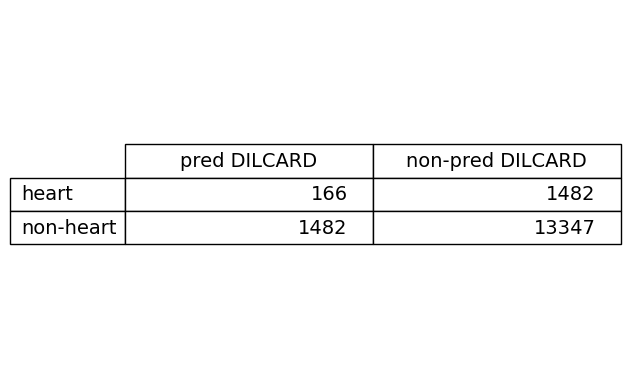

In [427]:
'''Construct a contingency matrix for Fisher's exact test'''
x1 = len(intersection(pred_causal, tissue_enriched))
x2 = len(intersection(non_pred_causal, tissue_enriched))
x3 = len(intersection(pred_causal, non_tissue_enriched))
x4 = len(intersection(non_pred_causal, non_tissue_enriched))

contingency_matrix = [[x1, x2], [x3, x4]]

# plot the contingency table
fig, ax = matplotlib.pyplot.subplots()
table = ax.table(contingency_matrix, 
                 rowLabels=[f'{TISSUE}', f'non-{TISSUE}'], 
                 colLabels=[f'pred {PHENOTYPE}', f'non-pred {PHENOTYPE}'], 
                 loc="center")
ax.axis('tight')
ax.axis('off')
table.set_fontsize(14)
table.scale(1,2)

In [428]:
''' 
Check if the ratio of predicted causal genes enriched in tissue is greater 
than the ratio of all genes enriched in the tissue

Note: alternative='greater' is the probability that a random table has x >= a, 
where contingency_matrix = [[a, b], [c, d]]
'''
_, p_tissue_expr = scipy.stats.fisher_exact(contingency_matrix, alternative='greater')

p_tissue_expr = format_pvalue(pvalue=p_tissue_expr)
print(f"{p_tissue_expr}")

p = 4.73e-01


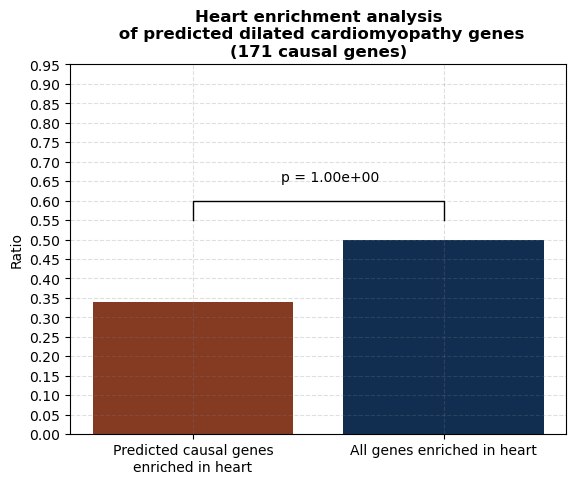

In [461]:
proportion1 = x1 / (x1 + x3)  # ratio of predicted causal genes that are enriched in tissue
proportion2 = (x1 + x2) / (x1 + x2 + x3 + x4)  # ratio of all genes that are enriched in tissue

labels = [f"Predicted causal genes\nenriched in {TISSUE}", 
          f"All genes enriched in {TISSUE}"]

matplotlib.pyplot.bar(x=labels, height=[proportion1, proportion2], color=['#853A22', '#112E51'])

# if statements below are convenient for plotting
if PHENOTYPE in ["MMAF", "NOA", "OG", "PCD", "POF"]:
    matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\n of predicted {PHENOTYPE} genes\n({len(ENSG2score_leaveOneOut)} causal genes)", weight='bold', fontsize=12)
elif PHENOTYPE == "BC":
    matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\n of predicted breast cancer genes\n({len(ENSG2score_leaveOneOut)} causal genes)", weight='bold', fontsize=12)
elif PHENOTYPE == "CC":
    matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\n of predicted colon cancer genes\n({len(ENSG2score_leaveOneOut)} causal genes)", weight='bold', fontsize=12)
elif PHENOTYPE == "HYPCARD":
    matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\n of predicted hypertrophic cardiomyopathy genes\n({len(ENSG2score_leaveOneOut)} causal genes)", weight='bold', fontsize=12)
elif PHENOTYPE == "DILCARD":
    matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\n of predicted dilated cardiomyopathy genes\n({len(ENSG2score_leaveOneOut)} causal genes)", weight='bold', fontsize=12)

# plot p-value
h = .1 * max(proportion1, proportion2)
y = max(proportion1, proportion2) + h

matplotlib.pyplot.plot([labels[0], labels[0], labels[1], labels[1]], [y, y+h, y+h, y], lw=1, c='black')
matplotlib.pyplot.text(x=0.35,y=y+2*h, s=f"{p_tissue_expr}")

y_max = 2*max(proportion1, proportion2)
matplotlib.pyplot.yticks(numpy.arange(0, y_max, 0.05))
matplotlib.pyplot.ylabel("Ratio")

matplotlib.pyplot.grid(True, linestyle='--', which='major',
                   color='grey', alpha=.25)

if SAVE_FIGURES:
    matplotlib.pyplot.savefig(FIGURES_DIR + f"{PHENOTYPE}_tissue_enrichment_GBA", dpi=1000)

#### Part 1.2. Tissue-enrichment validation: RWR

In [430]:
'''Load MultiXrank (RWR) scores and leave-one-out results'''
ENSG2score_RWR = parse_RWR_scores(RESULTS_RWR_FILE)

In [431]:
'''Get top x% of highest-scoring genes (including causal)'''
# due to obsolete GTEx data, some genes in the interactome need to be removed from the tissue enrichment analysis
for gene in interactome:
    if gene not in tissue_expr:
        del ENSG2score_RWR[gene]

results_RWR_sorted = sorted(ENSG2score_RWR.keys(), key=lambda item: ENSG2score_RWR[item], reverse=True)
pred_causal_RWR, non_pred_causal_RWR = take_top_percent(results_RWR_sorted, PRED_CAUSAL_DEF)

print(f"Selected {len(pred_causal_RWR)} higest-scoring genes")

Selected 1648 higest-scoring genes


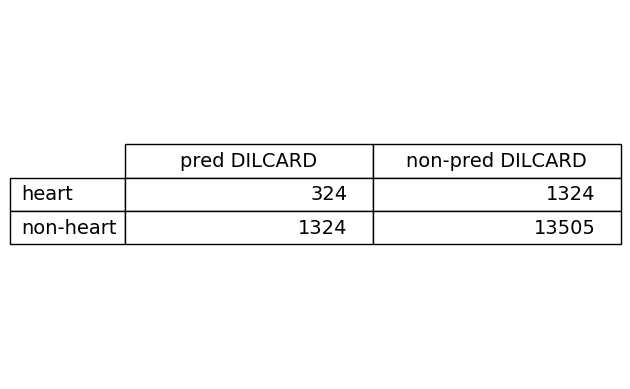

In [432]:
'''Construct a contingency matrix for Fisher's exact test'''
x1 = len(intersection(pred_causal_RWR, tissue_enriched))
x2 = len(intersection(non_pred_causal_RWR, tissue_enriched))
x3 = len(intersection(pred_causal_RWR, non_tissue_enriched))
x4 = len(intersection(non_pred_causal_RWR, non_tissue_enriched))

contingency_matrix = [[x1, x2], [x3, x4]]

# plot the contingency table
fig, ax = matplotlib.pyplot.subplots()
table = ax.table(contingency_matrix, 
                 rowLabels=[f'{TISSUE}', f'non-{TISSUE}'], 
                 colLabels=[f'pred {PHENOTYPE}', f'non-pred {PHENOTYPE}'], 
                 loc="center")
ax.axis('tight')
ax.axis('off')
table.set_fontsize(14)
table.scale(1,2)

In [433]:
''' 
Check if the ratio of predicted causal genes enriched in the tissue is greater 
than the ratio of all genes enriched in the tissue

Note: alternative='greater' is the probability that a random table has x >= a, 
where contingency_matrix = [[a, b], [c, d]]
'''
_, p_tissue_expr = scipy.stats.fisher_exact(contingency_matrix, alternative='greater')

p_tissue_expr = format_pvalue(pvalue=p_tissue_expr)
print(f"{p_tissue_expr}")

p < 10^-4****


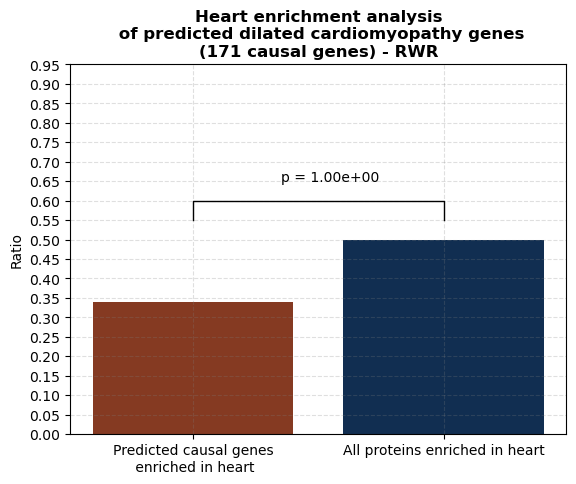

In [462]:
proportion1 = x1 / (x1 + x3)  # ratio of predicted causal genes that are enriched in tissue
proportion2 = (x1 + x2) / (x1 + x2 + x3 + x4)  # ratio of all genes that are enriched in tissue

labels = [f"Predicted causal genes\n enriched in {TISSUE}", 
          f"All proteins enriched in {TISSUE}"]

matplotlib.pyplot.bar(x=labels, height=[proportion1, proportion2], color=['#853A22', '#112E51'])

# if statements below are convenient for plotting
if PHENOTYPE in ["MMAF", "NOA", "OG", "PCD", "POF"]:
    matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\n of predicted {PHENOTYPE} genes\n({len(ENSG2score_leaveOneOut)} seed genes) - RWR", weight='bold', fontsize=12)
elif PHENOTYPE == "BC":
    matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\n of predicted breast cancer genes\n({len(ENSG2score_leaveOneOut)} causal genes) - RWR", weight='bold', fontsize=12)
elif PHENOTYPE == "CC":
    matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\n of predicted colon cancer genes\n({len(ENSG2score_leaveOneOut)} causal genes) - RWR", weight='bold', fontsize=12)
elif PHENOTYPE == "HYPCARD":
    matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\n of predicted hypertrophic cardiomyopathy genes\n({len(ENSG2score_leaveOneOut)} causal genes) - RWR", weight='bold', fontsize=12)
elif PHENOTYPE == "DILCARD":
    matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\n of predicted dilated cardiomyopathy genes\n({len(ENSG2score_leaveOneOut)} causal genes) - RWR", weight='bold', fontsize=12)

# plot p-value
h = .1 * max(proportion1, proportion2)
y = max(proportion1, proportion2) + h

matplotlib.pyplot.plot([labels[0], labels[0], labels[1], labels[1]], [y, y+h, y+h, y], lw=1, c='black')
matplotlib.pyplot.text(x=0.35,y=y+2*h, s=f"{p_tissue_expr}")

y_max = 2*max(proportion1, proportion2)
matplotlib.pyplot.yticks(numpy.arange(0, y_max, 0.05))
matplotlib.pyplot.ylabel("Ratio")

matplotlib.pyplot.grid(True, linestyle='--', which='major',
                   color='grey', alpha=.25)

if SAVE_FIGURES:
    matplotlib.pyplot.savefig(FIGURES_DIR + f"{PHENOTYPE}_tissue_enrichment_RWR", dpi=1000)

#### Part 1.3. Tissue-enrichment validation: PageRank

In [435]:
'''Calculate PageRank scores then sort them by descending scores'''
# causal_genes: dict of causal genes with key=ENSG, value=1
causal_genes = ENSG2score_leaveOneOut.copy()
for left_out in causal_genes:
    causal_genes[left_out] = 1

# use PageRank from NetworkX
ENSG2score_pagerank = networkx.pagerank(interactome, personalization=causal_genes, alpha=ALPHA)

In [436]:
'''Get top x% of highest-scoring genes (including causal)'''
# due to obsolete GTEx data, some genes in the interactome need to be removed from the tissue enrichment analysis
for gene in interactome:
    if gene not in tissue_expr:
        del ENSG2score_pagerank[gene]

results_pagerank_sorted = sorted(ENSG2score_pagerank.keys(), key=lambda item: ENSG2score_pagerank[item], reverse=True)
pred_causal_pagerank, non_pred_causal_pagerank = take_top_percent(results_pagerank_sorted, PRED_CAUSAL_DEF)

print(f"Selected {len(pred_causal_pagerank)} higest-scoring genes")

Selected 1648 higest-scoring genes


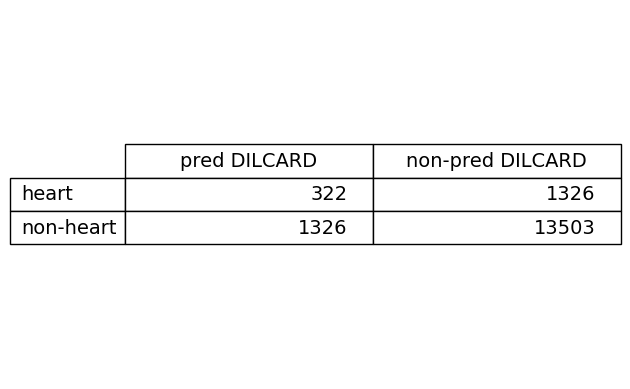

In [437]:
'''Construct a contingency matrix for Fisher's exact test'''
x1 = len(intersection(pred_causal_pagerank, tissue_enriched))
x2 = len(intersection(non_pred_causal_pagerank, tissue_enriched))
x3 = len(intersection(pred_causal_pagerank, non_tissue_enriched))
x4 = len(intersection(non_pred_causal_pagerank, non_tissue_enriched))

contingency_matrix = [[x1, x2], [x3, x4]]

# plot the contingency table
fig, ax = matplotlib.pyplot.subplots()
table = ax.table(contingency_matrix, 
                 rowLabels=[f'{TISSUE}', f'non-{TISSUE}'], 
                 colLabels=[f'pred {PHENOTYPE}', f'non-pred {PHENOTYPE}'], 
                 loc="center")
ax.axis('tight')
ax.axis('off')
table.set_fontsize(14)
table.scale(1,2)

In [438]:
''' 
Check if the ratio of predicted causal genes enriched in the tissue is greater 
than the ratio of all genes enriched in the tissue

Note: alternative='greater' is the probability that a random table has x >= a, 
where contingency_matrix = [[a, b], [c, d]]
'''
_, p_tissue_expr = scipy.stats.fisher_exact(contingency_matrix, alternative='greater')

p_tissue_expr = format_pvalue(pvalue=p_tissue_expr)
print(f"{p_tissue_expr}")

p < 10^-4****


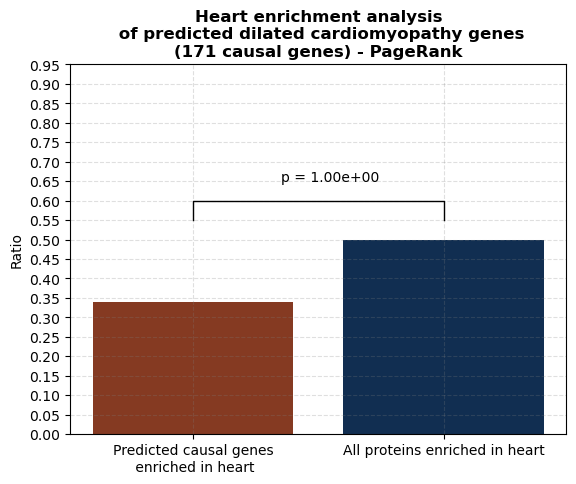

In [463]:
proportion1 = x1 / (x1 + x3)  # ratio of predicted causal genes that are enriched in tissue
proportion2 = (x1 + x2) / (x1 + x2 + x3 + x4)  # ratio of all genes that are enriched in tissue

labels = [f"Predicted causal genes\n enriched in {TISSUE}", 
          f"All proteins enriched in {TISSUE}"]

matplotlib.pyplot.bar(x=labels, height=[proportion1, proportion2], color=['#853A22', '#112E51'])

# if statements below are convenient for plotting
if PHENOTYPE in ["MMAF", "NOA", "OG", "PCD", "POF"]:
    matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\n of predicted {PHENOTYPE} genes\n({len(ENSG2score_leaveOneOut)} seed genes) - PageRank", weight='bold', fontsize=12)
elif PHENOTYPE == "BC":
    matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\n of predicted breast cancer genes\n({len(ENSG2score_leaveOneOut)} causal genes) - PageRank", weight='bold', fontsize=12)
elif PHENOTYPE == "CC":
    matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\n of predicted colon cancer genes\n({len(ENSG2score_leaveOneOut)} causal genes) - PageRank", weight='bold', fontsize=12)
elif PHENOTYPE == "HYPCARD":
    matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\n of predicted hypertrophic cardiomyopathy genes\n({len(ENSG2score_leaveOneOut)} causal genes) - PageRank", weight='bold', fontsize=12)
elif PHENOTYPE == "DILCARD":
    matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\n of predicted dilated cardiomyopathy genes\n({len(ENSG2score_leaveOneOut)} causal genes) - PageRank", weight='bold', fontsize=12)

# plot p-value
h = .1 * max(proportion1, proportion2)
y = max(proportion1, proportion2) + h

matplotlib.pyplot.plot([labels[0], labels[0], labels[1], labels[1]], [y, y+h, y+h, y], lw=1, c='black')
matplotlib.pyplot.text(x=0.35,y=y+2*h, s=f"{p_tissue_expr}")

y_max = 2*max(proportion1, proportion2)
matplotlib.pyplot.yticks(numpy.arange(0, y_max, 0.05))
matplotlib.pyplot.ylabel("Ratio")

matplotlib.pyplot.grid(True, linestyle='--', which='major',
                   color='grey', alpha=.25)

if SAVE_FIGURES:
    matplotlib.pyplot.savefig(FIGURES_DIR + f"{PHENOTYPE}_tissue_enrichment_PageRank", dpi=1000)

#### Part 1.4. Comparison of tissue enrichment: GBA centrality vs RWR vs PageRank

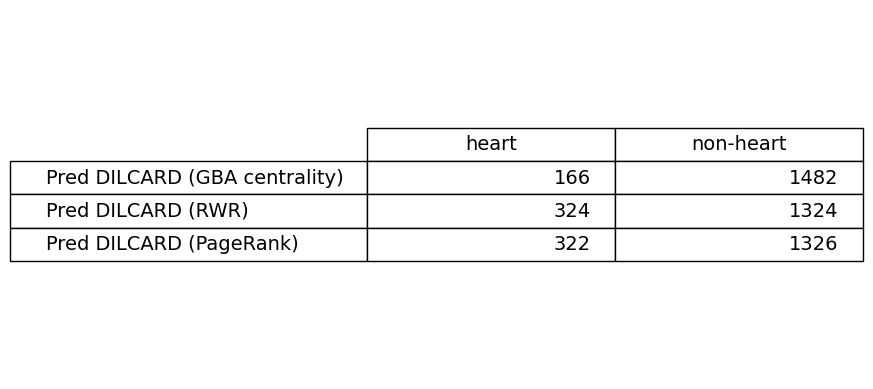

In [440]:
'''Construct a matrix to compare GBA centrality, RWR and PageRank'''
x1 = len(intersection(pred_causal, tissue_enriched))
x2 = len(intersection(pred_causal, non_tissue_enriched))
x3 = len(intersection(pred_causal_RWR, tissue_enriched))
x4 = len(intersection(pred_causal_RWR, non_tissue_enriched))
x5 = len(intersection(pred_causal_pagerank, tissue_enriched))
x6 = len(intersection(pred_causal_pagerank, non_tissue_enriched))

matrix = [[x1, x2], [x3, x4], [x5, x6]]

# plot the contingency table
fig, ax = matplotlib.pyplot.subplots()
table = ax.table(matrix, 
                 rowLabels=[f'Pred {PHENOTYPE} (GBA centrality)', f'Pred {PHENOTYPE} (RWR)', f'Pred {PHENOTYPE} (PageRank)'], 
                 colLabels=[f'{TISSUE}', f'non-{TISSUE}'], 
                 loc="center")
ax.axis('tight')
ax.axis('off')
table.set_fontsize(14)
table.scale(1,2)

#### GBA centrality vs RWR

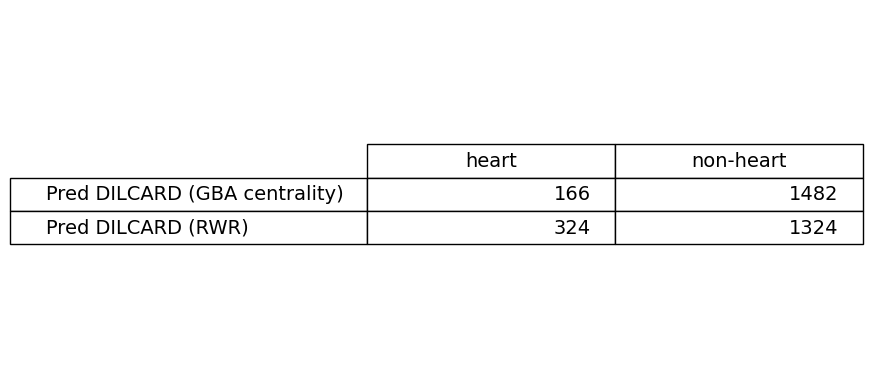

In [441]:
'''Construct a contingency matrix for Fisher's exact test to compare GBA centrality and RWR'''
x1 = len(intersection(pred_causal, tissue_enriched))
x2 = len(intersection(pred_causal, non_tissue_enriched))
x3 = len(intersection(pred_causal_RWR, tissue_enriched))
x4 = len(intersection(pred_causal_RWR, non_tissue_enriched))

contingency_matrix = [[x1, x2], [x3, x4]]

# plot the contingency table
fig, ax = matplotlib.pyplot.subplots()
table = ax.table(contingency_matrix, 
                 rowLabels=[f'Pred {PHENOTYPE} (GBA centrality)', f'Pred {PHENOTYPE} (RWR)'], 
                 colLabels=[f'{TISSUE}', f'non-{TISSUE}'], 
                 loc="center")
ax.axis('tight')
ax.axis('off')
table.set_fontsize(14)
table.scale(1,2)

In [442]:
''' 
Check if the ratio of predicted causal genes enriched in the tissue is greater
for GBA centrality than for RWR

Note: alternative='greater' is the probability that a random table has x >= a, 
where contingency_matrix = [[a, b], [c, d]]
'''
_, p_tissue_expr = scipy.stats.fisher_exact(contingency_matrix, alternative='greater')

p_tissue_expr = format_pvalue(pvalue=p_tissue_expr)
print(f"{p_tissue_expr}")

p = 1.00e+00


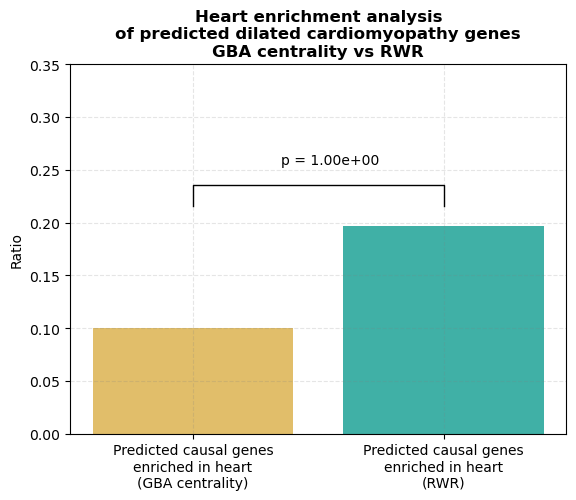

In [443]:
proportion1 = x1 / (x1 + x2)  # ratio of predicted causal genes that are tissue-enriched (GBA centrality)
proportion2 = x3 / (x3 + x4)  # ratio of predicted causal genes that are tissue-enriched (RWR)

labels = [f"Predicted causal genes\nenriched in {TISSUE}\n(GBA centrality)", 
          f"Predicted causal genes\nenriched in {TISSUE}\n(RWR)"]

matplotlib.pyplot.bar(x=labels, height=[proportion1, proportion2], color=['#E1BE6A', '#40B0A6'])

# if statements below are convenient for plotting
if PHENOTYPE in ["MMAF", "NOA", "OG", "PCD", "POF"]:
    matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\nof predicted {PHENOTYPE} genes\nGBA centrality vs RWR", weight='bold', fontsize=12)
elif PHENOTYPE == "BC":
    matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\nof predicted breast cancer genes\nGBA centrality vs RWR", weight='bold', fontsize=12)
elif PHENOTYPE == "CC":
    matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\nof predicted colon cancer genes\nGBA centrality vs RWR", weight='bold', fontsize=12)
elif PHENOTYPE == "HYPCARD":
    matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\nof predicted hypertrophic cardiomyopathy genes\nGBA centrality vs RWR", weight='bold', fontsize=12)
elif PHENOTYPE == "DILCARD":
    matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\nof predicted dilated cardiomyopathy genes\nGBA centrality vs RWR", weight='bold', fontsize=12)

# plot p-value
h = .1 * max(proportion1, proportion2)
y = max(proportion1, proportion2) + h

matplotlib.pyplot.plot([labels[0], labels[0], labels[1], labels[1]], [y, y+h, y+h, y], lw=1, c='black')
matplotlib.pyplot.text(x=0.35,y=y+2*h, s=f"{p_tissue_expr}")

y_max = 2*max(proportion1, proportion2)
matplotlib.pyplot.yticks(numpy.arange(0, y_max, 0.05))
matplotlib.pyplot.ylabel("Ratio")

matplotlib.pyplot.grid(True, linestyle='--', which='major',
                   color='grey', alpha=0.2)

if SAVE_FIGURES:
    matplotlib.pyplot.savefig(FIGURES_DIR + f"{PHENOTYPE}_tissue_enrichment_GBA_vs_RWR", dpi=1000)

#### GBA centrality vs PageRank

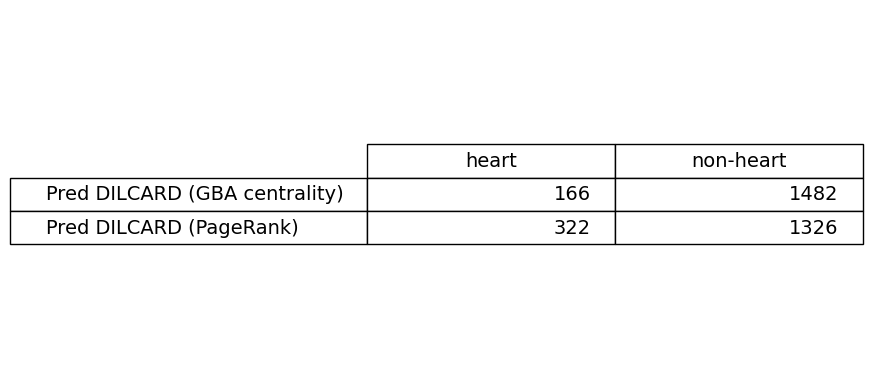

In [444]:
'''Construct a contingency matrix for Fisher's exact test to compare GBA centrality and PageRank'''
x1 = len(intersection(pred_causal, tissue_enriched))
x2 = len(intersection(pred_causal, non_tissue_enriched))
x3 = len(intersection(pred_causal_pagerank, tissue_enriched))
x4 = len(intersection(pred_causal_pagerank, non_tissue_enriched))

contingency_matrix = [[x1, x2], [x3, x4]]

# plot the contingency table
fig, ax = matplotlib.pyplot.subplots()
table = ax.table(contingency_matrix, 
                 rowLabels=[f'Pred {PHENOTYPE} (GBA centrality)', f'Pred {PHENOTYPE} (PageRank)'], 
                 colLabels=[f'{TISSUE}', f'non-{TISSUE}'], 
                 loc="center")
ax.axis('tight')
ax.axis('off')
table.set_fontsize(14)
table.scale(1,2)

In [445]:
''' 
Check if the ratio of predicted causal genes enriched in the tissue is greater
for GBA centrality than for PageRank

Note: alternative='greater' is the probability that a random table has x >= a, 
where contingency_matrix = [[a, b], [c, d]]
'''
_, p_tissue_expr = scipy.stats.fisher_exact(contingency_matrix, alternative='greater')

p_tissue_expr = format_pvalue(pvalue=p_tissue_expr)
print(f"{p_tissue_expr}")

p = 1.00e+00


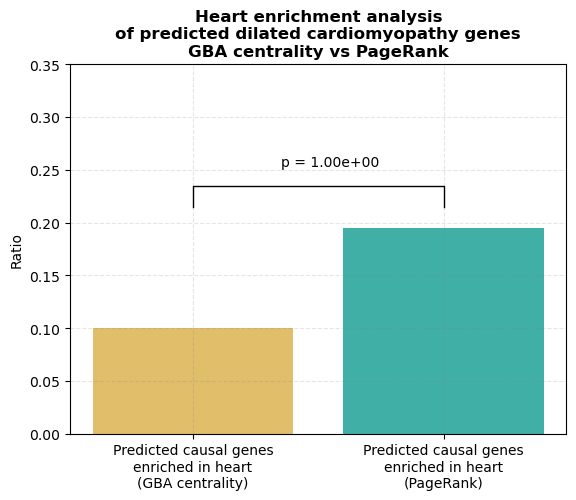

In [446]:
proportion1 = x1 / (x1 + x2)  # ratio of predicted causal genes that are tissue-enriched (GBA centrality)
proportion2 = x3 / (x3 + x4)  # ratio of predicted causal genes that are tissue-enriched (PageRank)

labels = [f"Predicted causal genes\nenriched in {TISSUE}\n(GBA centrality)", 
          f"Predicted causal genes\nenriched in {TISSUE}\n(PageRank)"]

matplotlib.pyplot.bar(x=labels, height=[proportion1, proportion2], color=['#E1BE6A', '#40B0A6'])

if PHENOTYPE in ["MMAF", "NOA", "OG", "PCD", "POF"]:
    matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\nof predicted {PHENOTYPE} genes\nGBA centrality vs PageRank", weight='bold', fontsize=12)
elif PHENOTYPE == "BC":
    matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\nof predicted breast cancer genes\nGBA centrality vs PageRank", weight='bold', fontsize=12)
elif PHENOTYPE == "CC":
    matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\nof predicted colon cancer genes\nGBA centrality vs PageRank", weight='bold', fontsize=12)
elif PHENOTYPE == "HYPCARD":
    matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\nof predicted hypertrophic cardiomyopathy genes\nGBA centrality vs PageRank", weight='bold', fontsize=12)
elif PHENOTYPE == "DILCARD":
    matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\nof predicted dilated cardiomyopathy genes\nGBA centrality vs PageRank", weight='bold', fontsize=12)


# plot p-value
h = .1 * max(proportion1, proportion2)
y = max(proportion1, proportion2) + h

matplotlib.pyplot.plot([labels[0], labels[0], labels[1], labels[1]], [y, y+h, y+h, y], lw=1, c='black')
matplotlib.pyplot.text(x=0.35,y=y+2*h, s=f"{p_tissue_expr}")

y_max = 2*max(proportion1, proportion2)
matplotlib.pyplot.yticks(numpy.arange(0, y_max, 0.05))
matplotlib.pyplot.ylabel("Ratio")

matplotlib.pyplot.grid(True, linestyle='--', which='major',
                   color='grey', alpha=0.2)

if SAVE_FIGURES:
    matplotlib.pyplot.savefig(FIGURES_DIR + f"{PHENOTYPE}_tissue_enrichment_GBA_vs_PageRank", dpi=1000)

### Part 2: Leave-one-out validation

In [447]:
def parse_GBA_ranks(ranks_file):
    '''
    Loads the ranks generated with run_GBA_centrality/leave_one_out.py --ranks
    Returns:
    - ENSG2rank: dict with key=ENSG, value=rank
    - gene2ENSG: dict with key=gene, value=ENSG
    - ENSG2gene: dict key=ENSG, value=gene
    '''
    ENSG2rank = {}
    gene2ENSG = {}
    ENSG2gene = {}

    try:
        f = open(ranks_file, 'r')
    except Exception as e:
        raise Exception("cannot open provided ranks file")

    line = f.readline()
    if not line.startswith("ENSG\t"):
        raise Exception("Ranks file problem")

    for line in f:
        split_line = line.rstrip().split('\t')

        ENSG, gene, rank = split_line

        ENSG2rank[ENSG] = int(rank)
        gene2ENSG[gene] = ENSG
        ENSG2gene[ENSG] = gene

    return(ENSG2rank, gene2ENSG, ENSG2gene)

In [448]:
def parse_RWR_ranks(ranks_file):
    '''
    Loads the ranks generated with run_MultiXrank/run_leave_one_out.py
    Returns:
    - ENSG2rank: dict with key=ENSG, value=rank
    '''
    ENSG2rank = {}

    try:
        f = open(ranks_file, 'r')
    except Exception as e:
        raise Exception("cannot open provided ranks file")

    for line in f:
        split_line = line.rstrip().split('\t')
        ENSG, rank = split_line
        ENSG2rank[ENSG] = int(rank)

    return(ENSG2rank)

In [449]:
def calculate_PageRank_ranks(causal_genes, interactome, alpha):
    # https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html

    # causal_genes: dict of causal genes with key=ENSG, value=1
    causal_genes = causal_genes.copy()
    for left_out in causal_genes:
        causal_genes[left_out] = 1

    ENSG2rank_pagerank = {}
    for left_out in list(causal_genes.keys()):
        del causal_genes[left_out]

        # calculate PageRank scores
        res_pagerank = networkx.pagerank(interactome, personalization=causal_genes, alpha=alpha)

        # save the left-out rank
        results_sorted = sorted(res_pagerank.keys(), key=lambda item: res_pagerank[item], reverse=True)
        rank_left_out = results_sorted.index(left_out) + 1  # + 1 because ranks start at 1 not 0
        ENSG2rank_pagerank[left_out] = rank_left_out

        # add left-out back to causal_genes
        causal_genes[left_out] = 1

    return(ENSG2rank_pagerank)

In [450]:
ENSG2rank_GBA, _, _ = parse_GBA_ranks(LEAVE_ONE_OUT_RANKS_FILE)
ENSG2rank_RWR = parse_RWR_ranks(LEAVE_ONE_OUT_RWR_RANKS_FILE)
ENSG2rank_pagerank = calculate_PageRank_ranks(causal_genes=ENSG2rank_GBA, interactome=interactome, alpha=ALPHA)

In [451]:
ranks_RWR = []
ranks_GBA = []
ranks_pagerank = []

for gene in ENSG2rank_RWR:
    ranks_RWR.append(ENSG2rank_RWR[gene])
    ranks_GBA.append(ENSG2rank_GBA[gene])
    ranks_pagerank.append(ENSG2rank_pagerank[gene])

In [452]:
# generate ranks with a random classifier
# use the integers method of a Generator instance instead of numpy.random.randint
# https://numpy.org/doc/2.1/reference/random/generated/numpy.random.randint.html
rng = numpy.random.default_rng()

# 1D numpy array for left-out known causal gene ranks
# size=len(left-out genes)
ranks_random = numpy.zeros(len(ENSG2rank_RWR), dtype=numpy.uint64)

n = 10000
for i in range(n):
    # 1D numpy array for left-out gene ranks
    # size=len(left-out genes)
    tmp = rng.integers(low=1, high=len(interactome), size=ranks_random.shape, dtype=numpy.uint64)
    tmp = numpy.sort(tmp)
    ranks_random += tmp

for j in range(len(ranks_random)):
    avg_rank = ranks_random[j] / n
    ranks_random[j] = avg_rank

In [453]:
curve_RWR = []
curve_GBA = []
curve_pagerank = []
curve_random = []

for i in range(len(interactome)):
    curve_RWR.append(sum(rank <= i for rank in ranks_RWR))
    curve_GBA.append(sum(rank <= i for rank in ranks_GBA))
    curve_pagerank.append(sum(rank <= i for rank in ranks_pagerank))
    curve_random.append(sum(rank <= i for rank in ranks_random))

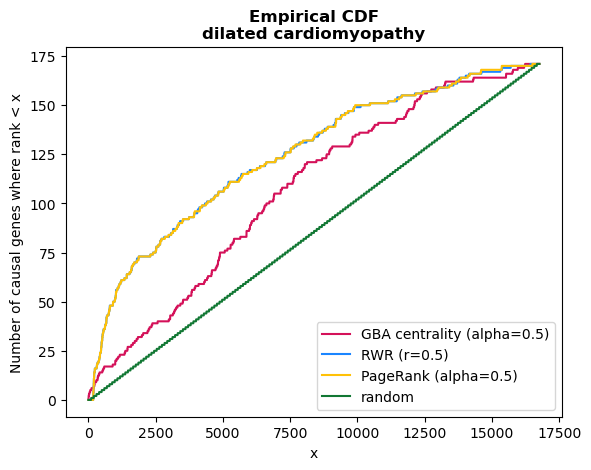

In [454]:
matplotlib.pyplot.plot(range(len(interactome)), curve_GBA, label=f"GBA centrality (alpha={ALPHA})", color="#D41159")
matplotlib.pyplot.plot(range(len(interactome)), curve_RWR, label=f"RWR (r={ALPHA})", color="#1A85FF")
matplotlib.pyplot.plot(range(len(interactome)), curve_pagerank, label=f"PageRank (alpha={ALPHA})", color="#FFC107")
matplotlib.pyplot.plot(range(len(interactome)), curve_random, label="random", color="#117733")

# if statements below are convenient for plotting
if PHENOTYPE in ["MMAF", "NOA", "OG", "PCD", "POF"]:
    matplotlib.pyplot.title(f"Empirical CDF\n{PHENOTYPE}", weight='bold', fontsize=12)
elif PHENOTYPE == "BC":
    matplotlib.pyplot.title(f"Empirical CDF\nbreast cancer", weight='bold', fontsize=12)
elif PHENOTYPE == "CC":
    matplotlib.pyplot.title(f"Empirical CDF\ncolon cancer", weight='bold', fontsize=12)
elif PHENOTYPE == "HYPCARD":
    matplotlib.pyplot.title(f"Empirical CDF\nhypertrophic cardiomyopathy", weight='bold', fontsize=12)
elif PHENOTYPE == "DILCARD":
    matplotlib.pyplot.title(f"Empirical CDF\ndilated cardiomyopathy", weight='bold', fontsize=12)

matplotlib.pyplot.xlabel("x")
matplotlib.pyplot.ylabel("Number of causal genes where rank < x")
matplotlib.pyplot.legend(loc='lower right')

if SAVE_FIGURES:
    matplotlib.pyplot.savefig(FIGURES_DIR + f"{PHENOTYPE}_CDF_GBA_vs_RWR_vs_PageRank", dpi=1000)

In [455]:
# "Are GBA centrality ranks higher than random classifier ranks?"
scipy.stats.wilcoxon(ranks_random, ranks_GBA, alternative="greater")

WilcoxonResult(statistic=10052.0, pvalue=1.5709361699159273e-05)

In [456]:
# "Are GBA centrality ranks higher than RWR ranks?"
scipy.stats.wilcoxon(ranks_RWR, ranks_GBA, alternative="greater")

WilcoxonResult(statistic=4588.0, pvalue=0.9999899927701227)

In [457]:
# "Are GBA centrality ranks higher than PageRank ranks?"
scipy.stats.wilcoxon(ranks_pagerank, ranks_GBA, alternative="greater")

WilcoxonResult(statistic=4600.0, pvalue=0.9999891297037408)

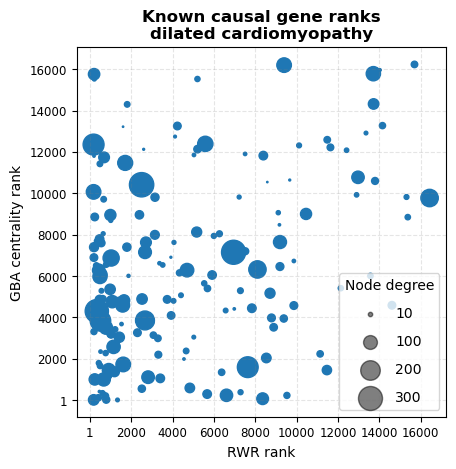

In [458]:
# compare GBA centrality rank vs RWR rank for each left-out gene, adjust point size by node degree
node_degrees = []
for gene in ENSG2rank_GBA:
    node_degrees.append(interactome.degree(gene))

matplotlib.pyplot.scatter(x=ranks_RWR, y=ranks_GBA, s=node_degrees)
matplotlib.pyplot.xlabel("RWR rank")
matplotlib.pyplot.ylabel("GBA centrality rank")

if PHENOTYPE in ["MMAF", "NOA", "OG", "PCD", "POF"]:
    matplotlib.pyplot.title(f"Known causal gene ranks\n{PHENOTYPE}", weight='bold', fontsize=12)
elif PHENOTYPE == "BC":
    matplotlib.pyplot.title(f"Known causal gene ranks\nbreast cancer", weight='bold', fontsize=12)
elif PHENOTYPE == "CC":
    matplotlib.pyplot.title(f"Known causal gene ranks\ncolon cancer", weight='bold', fontsize=12)
elif PHENOTYPE == "HYPCARD":
    matplotlib.pyplot.title(f"Known causal gene ranks\nhypertrophic cardiomyopathy", weight='bold', fontsize=12)
elif PHENOTYPE == "DILCARD":
    matplotlib.pyplot.title(f"Known causal gene ranks\ndilated cardiomyopathy", weight='bold', fontsize=12)

ticks  = numpy.arange(0, len(interactome), step=2000)
ticks[0] = 1
ticks = ticks[::-1]

matplotlib.pyplot.xticks(ticks, fontsize=8.5)
matplotlib.pyplot.yticks(ticks, fontsize=8.5)

matplotlib.pyplot.axis('square')

matplotlib.pyplot.grid(True, linestyle='--', which='major',
                   color='grey', alpha=0.2)

# add a legend for point size
for degree in [10, 100, 200, 300]:
    matplotlib.pyplot.scatter([], [], s=degree, c='k', alpha=0.5,
               label=str(degree))
matplotlib.pyplot.legend(scatterpoints=1, frameon=True, labelspacing=1, title='Node degree', loc='lower right')

if SAVE_FIGURES:
    matplotlib.pyplot.savefig(FIGURES_DIR + f"{PHENOTYPE}_scatter_GBA_vs_RWR", dpi=1000)

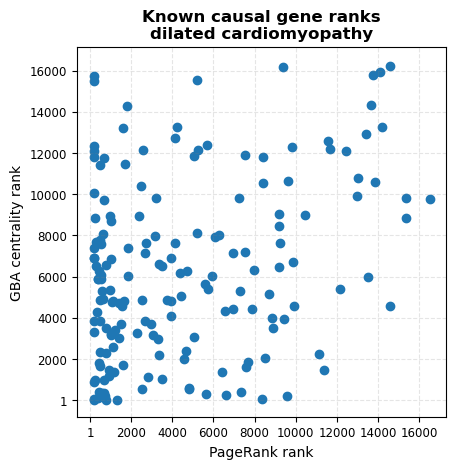

In [459]:
# compare GBA centrality rank vs PageRank rank for each left-out gene

matplotlib.pyplot.scatter(x=ranks_pagerank, y=ranks_GBA)
matplotlib.pyplot.xlabel("PageRank rank")
matplotlib.pyplot.ylabel("GBA centrality rank")

if PHENOTYPE in ["MMAF", "NOA", "OG", "PCD", "POF"]:
    matplotlib.pyplot.title(f"Known causal gene ranks\n{PHENOTYPE}", weight='bold', fontsize=12)
elif PHENOTYPE == "BC":
    matplotlib.pyplot.title(f"Known causal gene ranks\nbreast cancer", weight='bold', fontsize=12)
elif PHENOTYPE == "CC":
    matplotlib.pyplot.title(f"Known causal gene ranks\ncolon cancer", weight='bold', fontsize=12)
elif PHENOTYPE == "HYPCARD":
    matplotlib.pyplot.title(f"Known causal gene ranks\nhypertrophic cardiomyopathy", weight='bold', fontsize=12)
elif PHENOTYPE == "DILCARD":
    matplotlib.pyplot.title(f"Known causal gene ranks\ndilated cardiomyopathy", weight='bold', fontsize=12)

ticks  = numpy.arange(0, len(interactome), step=2000)
ticks[0] = 1
ticks = ticks[::-1]

matplotlib.pyplot.xticks(ticks, fontsize=8.5)
matplotlib.pyplot.yticks(ticks, fontsize=8.5)

matplotlib.pyplot.axis('square')

matplotlib.pyplot.grid(True, linestyle='--', which='major',
                   color='grey', alpha=0.2)

if SAVE_FIGURES:
    matplotlib.pyplot.savefig(FIGURES_DIR + f"{PHENOTYPE}_scatter_GBA_vs_PageRank", dpi=1000)

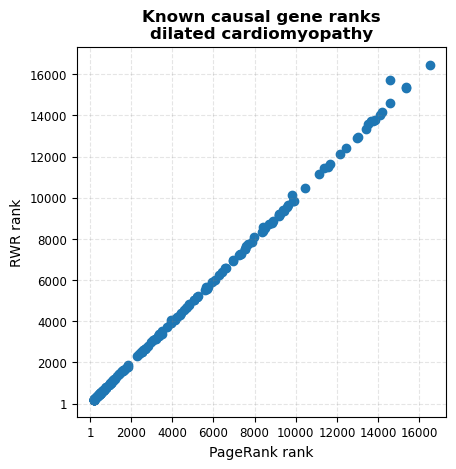

In [460]:
# compare RWR rank vs PageRank rank for each left-out gene

matplotlib.pyplot.scatter(x=ranks_pagerank, y=ranks_RWR)
matplotlib.pyplot.xlabel("PageRank rank")
matplotlib.pyplot.ylabel("RWR rank")

if PHENOTYPE in ["MMAF", "NOA", "OG", "PCD", "POF"]:
    matplotlib.pyplot.title(f"Known causal gene ranks\n{PHENOTYPE}", weight='bold', fontsize=12)
elif PHENOTYPE == "BC":
    matplotlib.pyplot.title(f"Known causal gene ranks\nbreast cancer", weight='bold', fontsize=12)
elif PHENOTYPE == "CC":
    matplotlib.pyplot.title(f"Known causal gene ranks\ncolon cancer", weight='bold', fontsize=12)
elif PHENOTYPE == "HYPCARD":
    matplotlib.pyplot.title(f"Known causal gene ranks\nhypertrophic cardiomyopathy", weight='bold', fontsize=12)
elif PHENOTYPE == "DILCARD":
    matplotlib.pyplot.title(f"Known causal gene ranks\ndilated cardiomyopathy", weight='bold', fontsize=12)

ticks  = numpy.arange(0, len(interactome), step=2000)
ticks[0] = 1
ticks = ticks[::-1]

matplotlib.pyplot.xticks(ticks, fontsize=8.5)
matplotlib.pyplot.yticks(ticks, fontsize=8.5)

matplotlib.pyplot.axis('square')

matplotlib.pyplot.grid(True, linestyle='--', which='major',
                   color='grey', alpha=0.2)

if SAVE_FIGURES:
    matplotlib.pyplot.savefig(FIGURES_DIR + f"{PHENOTYPE}_scatter_RWR_vs_PageRank", dpi=1000)